In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.__version__

'1.11.0'

In [3]:
import argparse

import numpy as np
import tensorflow as tf

from face_landmark import model
from face_landmark import load_dataset

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
!echo $CUDA_VISIBLE_DEVICES

0


In [145]:
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(target='', graph=graph0, config=config) as sess:
    image_tensor = tf.placeholder(dtype=tf.uint8, shape=[None, None, None, 3])
    x1 = (tf.cast(x=image_tensor, dtype=tf.float32) * 2.0 / 255.0) - 1.0
    x2 = tf.image.resize_images(x1, size=(256, 256))
    heatmap_inferred_tensors = model.fan(x=x2, num_modules=1)
    heatmap_inferred_t1_tensor = heatmap_inferred_tensors[0]
    heatmap_groundtruth_tensor = tf.placeholder(dtype=tf.float32, shape=[None, 64, 64, 68])
    loss_op = tf.losses.mean_squared_error(labels=heatmap_groundtruth_tensor, predictions=heatmap_inferred_t1_tensor)
    train_op = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss_op)
    
    
    init_op = tf.global_variables_initializer()
    
    sess.run(init_op)
    
    n_epoch = 200
    n_steps = len(data_iterator)

    for i_epoch in range(n_epoch):
        loss = 0.0
        for i_step, (image_sample, heatmap_sample) in enumerate(data_iterator):
            loss_i, _ = sess.run([loss_op, train_op], 
                                  feed_dict={image_tensor:[image_sample],
                                             heatmap_groundtruth_tensor:[heatmap_sample]})
            loss += loss_i
        print('epoch:', i_epoch, 'loss:', loss / n_steps)

epoch: 0 loss: 1.4368111226293776
epoch: 1 loss: 1.1972072124481201
epoch: 2 loss: 1.0517540739642248
epoch: 3 loss: 0.9463422927591536
epoch: 4 loss: 0.8636044992340935
epoch: 5 loss: 0.7953388161129422
epoch: 6 loss: 0.7372961507903205
epoch: 7 loss: 0.6870713068379296
epoch: 8 loss: 0.6428966853353713
epoch: 9 loss: 0.6035722196102142
epoch: 10 loss: 0.5681571596198611
epoch: 11 loss: 0.5359877049922943
epoch: 12 loss: 0.5066475023825964
epoch: 13 loss: 0.47977151970068616
epoch: 14 loss: 0.4550356964270274
epoch: 15 loss: 0.4321424000793033
epoch: 16 loss: 0.4108474552631378
epoch: 17 loss: 0.39097684456242454
epoch: 18 loss: 0.3723641468418969
epoch: 19 loss: 0.35488467249605393
epoch: 20 loss: 0.3384358170959685
epoch: 21 loss: 0.32292132410738206
epoch: 22 loss: 0.3082752111885283
epoch: 23 loss: 0.29442427721288467
epoch: 24 loss: 0.281302230225669
epoch: 25 loss: 0.2688538233439128
epoch: 26 loss: 0.25703509400288266
epoch: 27 loss: 0.2457987442612648
epoch: 28 loss: 0.2351071

In [6]:
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os

with tf.Session(target='', graph=graph0, config=config) as sess:
    record_path = '/barn2/yuan/datasets/300W_LP/flat_dataset.record'
    dataseto = load_dataset.Dataset()
    dataset = dataseto.get_tf_dataset(record_path, batch_size=16)
    dataset = dataset.prefetch(buffer_size=200)
    iterator = dataset.make_initializable_iterator()
    next_example = iterator.get_next()
    image_tensor, heatmap_groundtruth_tensor = next_example

    print(image_tensor)
    print(heatmap_groundtruth_tensor)
    
    heatmap_inferred_tensors = model.fan(x=image_tensor, num_modules=4)
    print('inferred length: ', len(heatmap_inferred_tensors))
    loss_op = 0.0
    for heatmap_inferred_tensor in heatmap_inferred_tensors:
        loss_op = loss_op + tf.losses.mean_squared_error(labels=heatmap_groundtruth_tensor, predictions=heatmap_inferred_tensor)
    train_op = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss_op)

    #init_op = tf.global_variables_initializer()
    
    #sess.run(init_op)
    
    #os.makedirs('./saved_model/face_landmark/20180921_01', exist_ok=True)
    saver = tf.train.Saver()
    saver.restore(sess, './saved_model/face_landmark/20180921_03')
    
    n_epoch = 200
    for i_epoch in range(n_epoch):
        sess.run(iterator.initializer)
        loss = 0.0
        n_steps = 0
        step_cnt = 0
        while True:
            step_cnt += 1
            try:
                loss_i, _ = sess.run([loss_op, train_op])
                loss += loss_i
                n_steps += 1
            except tf.errors.OutOfRangeError:
                saver.save(sess, '../saved_model/face_landmark/20180921_04')
                break
            if step_cnt % 20 == 0:
                print('epoch:', i_epoch + 1, 'step_cnt:', step_cnt, 'loss:', loss / n_steps)
                loss = 0.0
                n_steps = 0
        print('epoch:', i_epoch + 1, 'loss:', loss / n_steps)


Tensor("IteratorGetNext:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?, 64, 64, 68), dtype=float32)
in_channels: 64
out_channels: 128
in_channels: 128
out_channels: 256
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
inferred length:  4
INFO:tensorflow:Restoring parameters from ./saved_model/face_landmark/20180921_03
epoch: 1 step_cnt: 20 loss: 0.03415616592392325
epoch: 1 step_cnt: 40 loss: 0.03231698554009199
epoch: 1 step_cnt: 6

epoch: 1 step_cnt: 2960 loss: 0.03324242532253265
epoch: 1 step_cnt: 2980 loss: 0.03236772082746029
epoch: 1 step_cnt: 3000 loss: 0.027944712806493043
epoch: 1 step_cnt: 3020 loss: 0.0291796681471169
epoch: 1 step_cnt: 3040 loss: 0.028999062720686197
epoch: 1 step_cnt: 3060 loss: 0.03107542311772704
epoch: 1 step_cnt: 3080 loss: 0.028081505559384823
epoch: 1 step_cnt: 3100 loss: 0.030084767006337644
epoch: 1 step_cnt: 3120 loss: 0.02909640474244952
epoch: 1 step_cnt: 3140 loss: 0.02856795573607087
epoch: 1 step_cnt: 3160 loss: 0.029725464433431624
epoch: 1 step_cnt: 3180 loss: 0.02973742987960577
epoch: 1 step_cnt: 3200 loss: 0.030117755476385354
epoch: 1 step_cnt: 3220 loss: 0.028981282748281954
epoch: 1 step_cnt: 3240 loss: 0.030875839199870823
epoch: 1 step_cnt: 3260 loss: 0.03072961624711752
epoch: 1 step_cnt: 3280 loss: 0.029280302301049232
epoch: 1 step_cnt: 3300 loss: 0.02824040949344635
epoch: 1 step_cnt: 3320 loss: 0.028719586413353683
epoch: 1 step_cnt: 3340 loss: 0.028241222

epoch: 2 step_cnt: 2400 loss: 0.028696411941200494
epoch: 2 step_cnt: 2420 loss: 0.031185829360038043
epoch: 2 step_cnt: 2440 loss: 0.030687789712101222
epoch: 2 step_cnt: 2460 loss: 0.03231000863015652
epoch: 2 step_cnt: 2480 loss: 0.02876224396750331
epoch: 2 step_cnt: 2500 loss: 0.027682843245565893
epoch: 2 step_cnt: 2520 loss: 0.02606582920998335
epoch: 2 step_cnt: 2540 loss: 0.029453524388372898
epoch: 2 step_cnt: 2560 loss: 0.027696545142680405
epoch: 2 step_cnt: 2580 loss: 0.028190998639911414
epoch: 2 step_cnt: 2600 loss: 0.03156661698594689
epoch: 2 step_cnt: 2620 loss: 0.028652397356927393
epoch: 2 step_cnt: 2640 loss: 0.033435314707458016
epoch: 2 step_cnt: 2660 loss: 0.027600405365228654
epoch: 2 step_cnt: 2680 loss: 0.02801102278754115
epoch: 2 step_cnt: 2700 loss: 0.028073877561837435
epoch: 2 step_cnt: 2720 loss: 0.028339671716094018
epoch: 2 step_cnt: 2740 loss: 0.03015469005331397
epoch: 2 step_cnt: 2760 loss: 0.028390631545335054
epoch: 2 step_cnt: 2780 loss: 0.02920

epoch: 3 step_cnt: 1840 loss: 0.031245836056768894
epoch: 3 step_cnt: 1860 loss: 0.027236173488199712
epoch: 3 step_cnt: 1880 loss: 0.027035978715866806
epoch: 3 step_cnt: 1900 loss: 0.026999788638204337
epoch: 3 step_cnt: 1920 loss: 0.026329409331083298
epoch: 3 step_cnt: 1940 loss: 0.029754858836531638
epoch: 3 step_cnt: 1960 loss: 0.026760135404765607
epoch: 3 step_cnt: 1980 loss: 0.0281171633861959
epoch: 3 step_cnt: 2000 loss: 0.030625851452350618
epoch: 3 step_cnt: 2020 loss: 0.02981719532981515
epoch: 3 step_cnt: 2040 loss: 0.030987741984426977
epoch: 3 step_cnt: 2060 loss: 0.029555104672908783
epoch: 3 step_cnt: 2080 loss: 0.028598551452159882
epoch: 3 step_cnt: 2100 loss: 0.02920224964618683
epoch: 3 step_cnt: 2120 loss: 0.029082050919532774
epoch: 3 step_cnt: 2140 loss: 0.029865840543061496
epoch: 3 step_cnt: 2160 loss: 0.02813955321907997
epoch: 3 step_cnt: 2180 loss: 0.030751795507967472
epoch: 3 step_cnt: 2200 loss: 0.028198123909533024
epoch: 3 step_cnt: 2220 loss: 0.0301

KeyboardInterrupt: 

In [10]:
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os
import tensorflow as tf
from face_detection import face_detector
from face_landmark import model
from face_landmark import preprocess
import scipy



def generate_heatmap_v2(pts):
    h = 64
    w = 64
    c = pts.shape[0]
    assert pts.shape == (68, 2)
    heatmap = np.zeros((h, w, c), dtype=np.float32)
    pts = np.clip(pts, 0.0, 1-1e-7)
    for i in range(c):
        index_y = int(pts[i][1]*h)
        index_x = int(pts[i][0]*w)
        
        heatmap[index_y, index_x, i] = 1.0
    heatmap = scipy.ndimage.gaussian_filter(heatmap, sigma=10, mode='constant')
    max_itensity = heatmap.max(axis=(0,1))
    min_itensity = heatmap.min(axis=(0,1))
    scale = 2.0 / (max_itensity - min_itensity)
    mean = (max_itensity + min_itensity) / 2.0
    heatmap = (heatmap - mean) * scale
    heatmap = np.array(heatmap)
    return heatmap


def get_tf_dataset(record_path, batch_size=16, detector=None):
    def _parse_map_stage1(record):
        feature_dict = {}
        feature_dict['image/width'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/height'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/encoded'] = tf.FixedLenFeature([], dtype=tf.string)
        feature_dict['image/key/sha256'] = tf.FixedLenFeature([], dtype=tf.string)
        feature_dict['landmark/flatten'] = tf.VarLenFeature(dtype=tf.float32)
        example = tf.parse_single_example(record, features=feature_dict)

        image_width = example['image/width']
        image_height = example['image/height']
        image_encoded = example['image/encoded']
        image_decoded = tf.image.decode_jpeg(image_encoded, channels=3)

        image_id = example['image/key/sha256']
        landmark_t1 = example['landmark/flatten']
        landmark_t2 = tf.sparse_tensor_to_dense(landmark_t1)
        landmark = tf.reshape(landmark_t2, [68, 2])
        landmark = landmark / tf.cast([image_width, image_height], dtype=tf.float32)
        return [image_decoded, landmark]

    #def _parse_map_stage2a(image, landmark):
        #return self.auto_cropper.auto_crop(auto_crop(image_landmark))

    def _parse_map_stage2(image, landmark):
        try:
            bbx = detector.predict_1x1_raise(image, threshold=0.5)
            image, landmark = preprocess.train_preprocess(image, landmark, bbx)
        except face_detector.DetectionError:
            image, landmark = image, landmark
        return image, generate_heatmap_v2(landmark)


    def _parse_map_stage3(image, landmark):
        '''
        Recover shape since rank and shape info are lost in py_func (stage2) 
        '''
        image.set_shape([None, None, 3])
        x1 = (tf.cast(x=image, dtype=tf.float32) * 2.0 / 255.0) - 1.0
        x2 = tf.image.resize_images(x1, size=(256, 256))
        landmark.set_shape([64, 64, 68])
        return x2, landmark


    filenames = [record_path]
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.map(_parse_map_stage1, num_parallel_calls=32)

    dataset = dataset.map(lambda img, ldm: tuple(tf.py_func(_parse_map_stage2, inp=[img, ldm], Tout=[tf.uint8, tf.float32])))
    dataset = dataset.map(_parse_map_stage3, num_parallel_calls=32)
    dataset = dataset.batch(batch_size)
    return dataset

with tf.Session(target='', graph=graph0, config=config) as sess:
    record_path = '/barn2/yuan/datasets/300W_LP/flat_dataset.record'
    detector = face_detector.FaceDetector()
    dataset = get_tf_dataset(record_path, batch_size=16, detector=detector)
    dataset = dataset.prefetch(buffer_size=200)
    iterator = dataset.make_initializable_iterator()
    next_example = iterator.get_next()
    image_tensor, heatmap_groundtruth_tensor = next_example

    print(image_tensor)
    print(heatmap_groundtruth_tensor)
    
    heatmap_inferred_tensors = model.fan(x=image_tensor, num_modules=4)
    print('inferred length: ', len(heatmap_inferred_tensors))
    loss_op = 0.0
    for heatmap_inferred_tensor in heatmap_inferred_tensors:
        loss_op = loss_op + tf.losses.mean_squared_error(labels=heatmap_groundtruth_tensor, predictions=heatmap_inferred_tensor)
    train_op = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss_op)

    #init_op = tf.global_variables_initializer()
    
    #sess.run(init_op)
    
    #os.makedirs('./saved_model/face_landmark/20180921_01', exist_ok=True)
    saver = tf.train.Saver()
    saver.restore(sess, '../saved_model/face_landmark/20180921_04')
    
    n_epoch = 200
    for i_epoch in range(n_epoch):
        sess.run(iterator.initializer)
        loss = 0.0
        n_steps = 0
        step_cnt = 0
        while True:
            step_cnt += 1
            try:
                loss_i, _ = sess.run([loss_op, train_op])
                loss += loss_i
                n_steps += 1
            except tf.errors.OutOfRangeError:
                saver.save(sess, '../saved_model/face_landmark/20180921_05')
                break
            if step_cnt % 20 == 0:
                print('epoch:', i_epoch + 1, 'step_cnt:', step_cnt, 'loss:', loss / n_steps)
                loss = 0.0
                n_steps = 0
        print('epoch:', i_epoch + 1, 'loss:', loss / n_steps)


Tensor("IteratorGetNext:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?, 64, 64, 68), dtype=float32)
in_channels: 64
out_channels: 128
in_channels: 128
out_channels: 256
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
inferred length:  4
INFO:tensorflow:Restoring parameters from ../saved_model/face_landmark/20180921_04
epoch: 1 step_cnt: 20 loss: 0.8020052552223206
epoch: 1 step_cnt: 40 loss: 0.4319709435105324


KeyboardInterrupt: 

In [89]:

def get_tf_dataset(record_path, batch_size=16, detector=None):
    def _parse_map_stage5(record):
        feature_dict = {}
        feature_dict['image/width'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/height'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/encoded'] = tf.FixedLenFeature([], dtype=tf.string)
        feature_dict['image/key/sha256'] = tf.FixedLenFeature([], dtype=tf.string)
        feature_dict['landmark/flatten'] = tf.VarLenFeature(dtype=tf.float32)
        example = tf.parse_single_example(record, features=feature_dict)

        image_width = example['image/width']
        image_height = example['image/height']
        image_encoded = example['image/encoded']
        image_decoded = tf.image.decode_jpeg(image_encoded, channels=3)

        image_id = example['image/key/sha256']
        landmark_t1 = example['landmark/flatten']
        landmark_t2 = tf.sparse_tensor_to_dense(landmark_t1)
        landmark = tf.reshape(landmark_t2, [68, 2])
        landmark = landmark / tf.cast([image_width, image_height], dtype=tf.float32)
        return [image_decoded, landmark]

    def _parse_map_stage1(record):
        feature_dict = {}
        feature_dict['image/width'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/height'] = tf.FixedLenFeature([], dtype=tf.int64)
        feature_dict['image/encoded'] = tf.FixedLenFeature([], dtype=tf.string)
        #feature_dict['image/key/sha256'] = tf.FixedLenFeature([], dtype=tf.string)
        feature_dict['landmark/flatten'] = tf.VarLenFeature(dtype=tf.float32)
        #feature_dict['landmark/shape'] = tf.FixedLenFeature([], dtype=tf.int64)
        example = tf.parse_single_example(record, features=feature_dict)

        image_width = example['image/width']
        image_height = example['image/height']
        image_encoded = example['image/encoded']
        image_decoded = tf.image.decode_jpeg(image_encoded, channels=3)

        #image_id = example['image/key/sha256']
        landmark = example['landmark/flatten'] 
        #landmark_shape = example['landmark/shape']
        landmark = tf.sparse_tensor_to_dense(landmark)
        landmark = tf.reshape(landmark, [68, 2])
        landmark = landmark / tf.cast([image_width, image_height], dtype=tf.float32)
        return [image_decoded, landmark]
 
    
    
    #def _parse_map_stage2a(image, landmark):
        #return self.auto_cropper.auto_crop(auto_crop(image_landmark))

    def _parse_map_stage2(image, landmark):
        try:
            bbx = detector.predict_1x1_raise(image, threshold=0.94)
            image, landmark = preprocess.train_preprocess(image, landmark, bbx)
        except face_detector.DetectionError:
            image, landmark = image, landmark
        return image, preprocess.pts2heatmap(landmark, sigma=1.0)


    def _parse_map_stage3(image, landmark):
        '''
        Recover shape since rank and shape info are lost in py_func (stage2) 
        '''
        image.set_shape([None, None, 3])
        x1 = (tf.cast(x=image, dtype=tf.float32) * 2.0 / 255.0) - 1.0
        x2 = tf.image.resize_images(x1, size=(256, 256))
        landmark.set_shape([64, 64, 68])
        return x2, landmark


    filenames = [record_path]
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.map(_parse_map_stage1, num_parallel_calls=32)

    dataset = dataset.map(lambda img, ldm: tuple(tf.py_func(_parse_map_stage2, inp=[img, ldm], Tout=[tf.uint8, tf.float32])))
    dataset = dataset.map(_parse_map_stage3, num_parallel_calls=32)
    dataset = dataset.batch(batch_size)
    return dataset

In [29]:
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os
import tensorflow as tf
from face_detection import face_detector
from face_landmark import model
from face_landmark import preprocess
import scipy



with tf.Session(target='', graph=graph0, config=config) as sess:
    detector = face_detector.FaceDetector()
    dataset = infer.get_tf_dataset('/barn2/yuan/datasets/300wlp_20181002.tfrecord', batch_size=1, detector=detector)
    
    dataset = dataset.prefetch(buffer_size=200)
    iterator = dataset.make_initializable_iterator()
    next_example = iterator.get_next()
    image_tensor, heatmap_groundtruth_tensor = next_example

    print(image_tensor)
    print(heatmap_groundtruth_tensor)
    
    heatmap_inferred_tensors = model.fan(x=image_tensor, num_modules=4)
    print('inferred length: ', len(heatmap_inferred_tensors))
    loss_op = 0.0
    for heatmap_inferred_tensor in heatmap_inferred_tensors:
        loss_op = loss_op + tf.losses.mean_squared_error(labels=heatmap_groundtruth_tensor, predictions=heatmap_inferred_tensor)
    train_op = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss_op)

    #init_op = tf.global_variables_initializer()
    
    #sess.run(init_op)
    
    #os.makedirs('./saved_model/face_landmark/20180921_01', exist_ok=True)
    saver = tf.train.Saver()
    saver.restore(sess, '../saved_model/face_landmark/20180921_06')
    
    n_epoch = 200
    for i_epoch in range(n_epoch):
        sess.run(iterator.initializer)
        loss = 0.0
        n_steps = 0
        step_cnt = 0
        while True:
            step_cnt += 1
            try:
                loss_i, _ = sess.run([loss_op, train_op])
                loss += loss_i
                n_steps += 1
            except tf.errors.OutOfRangeError:
                saver.save(sess, '../saved_model/face_landmark/20180921_07')
                break
            if step_cnt % 20 == 0:
                print('epoch:', i_epoch + 1, 'step_cnt:', step_cnt, 'loss:', loss / n_steps)
                loss = 0.0
                n_steps = 0
        print('epoch:', i_epoch + 1, 'loss:', loss / n_steps)


Tensor("IteratorGetNext:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?, 64, 64, 68), dtype=float32)
in_channels: 64
out_channels: 128
in_channels: 128
out_channels: 256
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
inferred length:  4
INFO:tensorflow:Restoring parameters from ../saved_model/face_landmark/20180921_06
epoch: 1 step_cnt: 20 loss: 0.013609866052865982
epoch: 1 step_cnt: 40 loss: 0.015124871162697673
epoch: 1 step_cnt

epoch: 1 step_cnt: 2920 loss: 0.01459111855365336
epoch: 1 step_cnt: 2940 loss: 0.013276353850960732
epoch: 1 step_cnt: 2960 loss: 0.014499056152999401
epoch: 1 step_cnt: 2980 loss: 0.013227891875430942
epoch: 1 step_cnt: 3000 loss: 0.014049981255084276
epoch: 1 step_cnt: 3020 loss: 0.014480459224432706
epoch: 1 step_cnt: 3040 loss: 0.014399979263544083
epoch: 1 step_cnt: 3060 loss: 0.013746248139068485
epoch: 1 step_cnt: 3080 loss: 0.012370673520490528
epoch: 1 step_cnt: 3100 loss: 0.014993820851668716
epoch: 1 step_cnt: 3120 loss: 0.014988416712731123
epoch: 1 step_cnt: 3140 loss: 0.012982331309467554
epoch: 1 step_cnt: 3160 loss: 0.01516922414302826
epoch: 1 step_cnt: 3180 loss: 0.014978188555687666
epoch: 1 step_cnt: 3200 loss: 0.013658268097788095
epoch: 1 step_cnt: 3220 loss: 0.014871836779639125
epoch: 1 step_cnt: 3240 loss: 0.015094751445576548
epoch: 1 step_cnt: 3260 loss: 0.013454702775925398
epoch: 1 step_cnt: 3280 loss: 0.015906229335814714
epoch: 1 step_cnt: 3300 loss: 0.0

epoch: 1 step_cnt: 6160 loss: 0.013151622284203768
epoch: 1 step_cnt: 6180 loss: 0.013911588210612535
epoch: 1 step_cnt: 6200 loss: 0.012155064940452575
epoch: 1 step_cnt: 6220 loss: 0.013775472296401858
epoch: 1 step_cnt: 6240 loss: 0.014358264580368995
epoch: 1 step_cnt: 6260 loss: 0.01377201098948717
epoch: 1 step_cnt: 6280 loss: 0.013787898514419795
epoch: 1 step_cnt: 6300 loss: 0.014460762171074748
epoch: 1 step_cnt: 6320 loss: 0.014308250974863768
epoch: 1 step_cnt: 6340 loss: 0.013205779204145073
epoch: 1 step_cnt: 6360 loss: 0.013810667628422379
epoch: 1 step_cnt: 6380 loss: 0.012561382073909045
epoch: 1 step_cnt: 6400 loss: 0.013596803601831197
epoch: 1 step_cnt: 6420 loss: 0.013759971456602215
epoch: 1 step_cnt: 6440 loss: 0.014625932043418288
epoch: 1 step_cnt: 6460 loss: 0.015778465662151575
epoch: 1 step_cnt: 6480 loss: 0.01415136712603271
epoch: 1 step_cnt: 6500 loss: 0.014250030741095543
epoch: 1 step_cnt: 6520 loss: 0.014088274771347642
epoch: 1 step_cnt: 6540 loss: 0.0

epoch: 1 step_cnt: 9400 loss: 0.013481043837964534
epoch: 1 step_cnt: 9420 loss: 0.01490223635919392
epoch: 1 step_cnt: 9440 loss: 0.012095209769904613
epoch: 1 step_cnt: 9460 loss: 0.013712553074583411
epoch: 1 step_cnt: 9480 loss: 0.012391686672344804
epoch: 1 step_cnt: 9500 loss: 0.015175559930503369
epoch: 1 step_cnt: 9520 loss: 0.014102535136044026
epoch: 1 step_cnt: 9540 loss: 0.01173548735678196
epoch: 1 step_cnt: 9560 loss: 0.013840604200959205
epoch: 1 step_cnt: 9580 loss: 0.013672772981226444
epoch: 1 step_cnt: 9600 loss: 0.01192816225811839
epoch: 1 step_cnt: 9620 loss: 0.01531124752946198
epoch: 1 step_cnt: 9640 loss: 0.013034496642649173
epoch: 1 step_cnt: 9660 loss: 0.013877305760979652
epoch: 1 step_cnt: 9680 loss: 0.014319935580715537
epoch: 1 step_cnt: 9700 loss: 0.015035883197560907
epoch: 1 step_cnt: 9720 loss: 0.015038153016939759
epoch: 1 step_cnt: 9740 loss: 0.012979770777747035
epoch: 1 step_cnt: 9760 loss: 0.01266542742960155
epoch: 1 step_cnt: 9780 loss: 0.0142

epoch: 1 step_cnt: 12580 loss: 0.012715671816840768
epoch: 1 step_cnt: 12600 loss: 0.01384412362240255
epoch: 1 step_cnt: 12620 loss: 0.013527678605169059
epoch: 1 step_cnt: 12640 loss: 0.013282325211912393
epoch: 1 step_cnt: 12660 loss: 0.0150299409404397
epoch: 1 step_cnt: 12680 loss: 0.01276417844928801
epoch: 1 step_cnt: 12700 loss: 0.01428946815431118
epoch: 1 step_cnt: 12720 loss: 0.01463289218954742
epoch: 1 step_cnt: 12740 loss: 0.012934606475755572
epoch: 1 step_cnt: 12760 loss: 0.013391331071034074
epoch: 1 step_cnt: 12780 loss: 0.012894102651625872
epoch: 1 step_cnt: 12800 loss: 0.013904130784794688
epoch: 1 step_cnt: 12820 loss: 0.0132781105581671
epoch: 1 step_cnt: 12840 loss: 0.013438643421977758
epoch: 1 step_cnt: 12860 loss: 0.014185701915994286
epoch: 1 step_cnt: 12880 loss: 0.014140626788139344
epoch: 1 step_cnt: 12900 loss: 0.012767206924036146
epoch: 1 step_cnt: 12920 loss: 0.013824949506670237
epoch: 1 step_cnt: 12940 loss: 0.011591827450320124
epoch: 1 step_cnt: 1

epoch: 1 step_cnt: 15760 loss: 0.013267609477043151
epoch: 1 step_cnt: 15780 loss: 0.013248054031282663
epoch: 1 step_cnt: 15800 loss: 0.013575316360220312
epoch: 1 step_cnt: 15820 loss: 0.01338181523606181
epoch: 1 step_cnt: 15840 loss: 0.014319949224591256
epoch: 1 step_cnt: 15860 loss: 0.012923026643693446
epoch: 1 step_cnt: 15880 loss: 0.012240479048341513
epoch: 1 step_cnt: 15900 loss: 0.013919071527197957
epoch: 1 step_cnt: 15920 loss: 0.012798643251881004
epoch: 1 step_cnt: 15940 loss: 0.012635762616991997
epoch: 1 step_cnt: 15960 loss: 0.013197788642719388
epoch: 1 step_cnt: 15980 loss: 0.01424760464578867
epoch: 1 step_cnt: 16000 loss: 0.012973398063331842
epoch: 1 step_cnt: 16020 loss: 0.0132890441454947
epoch: 1 step_cnt: 16040 loss: 0.01451297509483993
epoch: 1 step_cnt: 16060 loss: 0.01312515139579773
epoch: 1 step_cnt: 16080 loss: 0.013744753785431385
epoch: 1 step_cnt: 16100 loss: 0.014395261788740754
epoch: 1 step_cnt: 16120 loss: 0.01350151035003364
epoch: 1 step_cnt: 

epoch: 1 step_cnt: 18940 loss: 0.012419949099421502
epoch: 1 step_cnt: 18960 loss: 0.014369431976228952
epoch: 1 step_cnt: 18980 loss: 0.012887573055922984
epoch: 1 step_cnt: 19000 loss: 0.014169453363865613
epoch: 1 step_cnt: 19020 loss: 0.014088756032288074
epoch: 1 step_cnt: 19040 loss: 0.012015648698434234
epoch: 1 step_cnt: 19060 loss: 0.015110780810937285
epoch: 1 step_cnt: 19080 loss: 0.013494529016315936
epoch: 1 step_cnt: 19100 loss: 0.012354090390726925
epoch: 1 step_cnt: 19120 loss: 0.013660396821796894
epoch: 1 step_cnt: 19140 loss: 0.012514774082228541
epoch: 1 step_cnt: 19160 loss: 0.012841444276273251
epoch: 1 step_cnt: 19180 loss: 0.01259641400538385
epoch: 1 step_cnt: 19200 loss: 0.013877292396500707
epoch: 1 step_cnt: 19220 loss: 0.013034891989082097
epoch: 1 step_cnt: 19240 loss: 0.014169094990938902
epoch: 1 step_cnt: 19260 loss: 0.01292746476829052
epoch: 1 step_cnt: 19280 loss: 0.011730088014155626
epoch: 1 step_cnt: 19300 loss: 0.01366453431546688
epoch: 1 step_c

epoch: 1 step_cnt: 22120 loss: 0.01197813511826098
epoch: 1 step_cnt: 22140 loss: 0.013335077371448279
epoch: 1 step_cnt: 22160 loss: 0.012580385012552143
epoch: 1 step_cnt: 22180 loss: 0.01265051756054163
epoch: 1 step_cnt: 22200 loss: 0.01267197229899466
epoch: 1 step_cnt: 22220 loss: 0.012031428376212716
epoch: 1 step_cnt: 22240 loss: 0.014572204602882267
epoch: 1 step_cnt: 22260 loss: 0.013001979468390346
epoch: 1 step_cnt: 22280 loss: 0.013286343542858958
epoch: 1 step_cnt: 22300 loss: 0.013591534784063697
epoch: 1 step_cnt: 22320 loss: 0.014159157685935498
epoch: 1 step_cnt: 22340 loss: 0.012308862758800387
epoch: 1 step_cnt: 22360 loss: 0.013724163314327598
epoch: 1 step_cnt: 22380 loss: 0.01262822961434722
epoch: 1 step_cnt: 22400 loss: 0.012703861203044653
epoch: 1 step_cnt: 22420 loss: 0.012055438151583076
epoch: 1 step_cnt: 22440 loss: 0.012253901269286872
epoch: 1 step_cnt: 22460 loss: 0.012937806406989693
epoch: 1 step_cnt: 22480 loss: 0.0127035369630903
epoch: 1 step_cnt:

epoch: 1 step_cnt: 25300 loss: 0.013453639624640346
epoch: 1 step_cnt: 25320 loss: 0.011878106044605374
epoch: 1 step_cnt: 25340 loss: 0.0124689316842705
epoch: 1 step_cnt: 25360 loss: 0.012685848399996758
epoch: 1 step_cnt: 25380 loss: 0.012145632226020098
epoch: 1 step_cnt: 25400 loss: 0.01356211444362998
epoch: 1 step_cnt: 25420 loss: 0.013210962386801839
epoch: 1 step_cnt: 25440 loss: 0.013739248691126704
epoch: 1 step_cnt: 25460 loss: 0.011686246609315276
epoch: 1 step_cnt: 25480 loss: 0.013313607219606638
epoch: 1 step_cnt: 25500 loss: 0.01146903084591031
epoch: 1 step_cnt: 25520 loss: 0.012490082997828722
epoch: 1 step_cnt: 25540 loss: 0.013163024792447686
epoch: 1 step_cnt: 25560 loss: 0.01259582182392478
epoch: 1 step_cnt: 25580 loss: 0.012876671133562922
epoch: 1 step_cnt: 25600 loss: 0.01417539669200778
epoch: 1 step_cnt: 25620 loss: 0.012422319082543255
epoch: 1 step_cnt: 25640 loss: 0.013514954177662731
epoch: 1 step_cnt: 25660 loss: 0.012831149715930223
epoch: 1 step_cnt:

epoch: 1 step_cnt: 28480 loss: 0.012482692440971731
epoch: 1 step_cnt: 28500 loss: 0.013372011482715607
epoch: 1 step_cnt: 28520 loss: 0.012447830336168409
epoch: 1 step_cnt: 28540 loss: 0.013642739551141859
epoch: 1 step_cnt: 28560 loss: 0.014310773881152272
epoch: 1 step_cnt: 28580 loss: 0.0117850995156914
epoch: 1 step_cnt: 28600 loss: 0.012283118767663836
epoch: 1 step_cnt: 28620 loss: 0.013301337137818336
epoch: 1 step_cnt: 28640 loss: 0.011774672800675035
epoch: 1 step_cnt: 28660 loss: 0.013571957685053348
epoch: 1 step_cnt: 28680 loss: 0.012033013859763741
epoch: 1 step_cnt: 28700 loss: 0.013441418530419469
epoch: 1 step_cnt: 28720 loss: 0.012232849514111877
epoch: 1 step_cnt: 28740 loss: 0.011933003738522529
epoch: 1 step_cnt: 28760 loss: 0.012100324220955371
epoch: 1 step_cnt: 28780 loss: 0.013131573610007764
epoch: 1 step_cnt: 28800 loss: 0.013991882652044296
epoch: 1 step_cnt: 28820 loss: 0.012860810896381736
epoch: 1 step_cnt: 28840 loss: 0.011955306166782975
epoch: 1 step_

epoch: 1 step_cnt: 31640 loss: 0.012956647155806422
epoch: 1 step_cnt: 31660 loss: 0.014596652146428824
epoch: 1 step_cnt: 31680 loss: 0.013147698296234012
epoch: 1 step_cnt: 31700 loss: 0.01233541420660913
epoch: 1 step_cnt: 31720 loss: 0.011910913698375224
epoch: 1 step_cnt: 31740 loss: 0.011848337529227138
epoch: 1 step_cnt: 31760 loss: 0.012475337646901608
epoch: 1 step_cnt: 31780 loss: 0.012860830733552575
epoch: 1 step_cnt: 31800 loss: 0.012068736972287298
epoch: 1 step_cnt: 31820 loss: 0.013165517710149288
epoch: 1 step_cnt: 31840 loss: 0.012275382690131665
epoch: 1 step_cnt: 31860 loss: 0.012235304340720177
epoch: 1 step_cnt: 31880 loss: 0.01233778209425509
epoch: 1 step_cnt: 31900 loss: 0.012995439628139139
epoch: 1 step_cnt: 31920 loss: 0.012015701737254858
epoch: 1 step_cnt: 31940 loss: 0.013265271298587322
epoch: 1 step_cnt: 31960 loss: 0.012825665576383472
epoch: 1 step_cnt: 31980 loss: 0.011579155549407005
epoch: 1 step_cnt: 32000 loss: 0.012612831266596913
epoch: 1 step_

KeyboardInterrupt: 

Tensor("IteratorGetNext:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?, 64, 64, 68), dtype=float32)
in_channels: 64
out_channels: 128
in_channels: 128
out_channels: 256
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
inferred length:  4
INFO:tensorflow:Restoring parameters from ../saved_model/face_landmark/80_8890_015


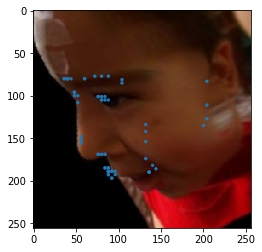

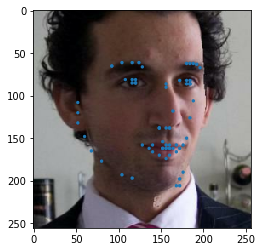

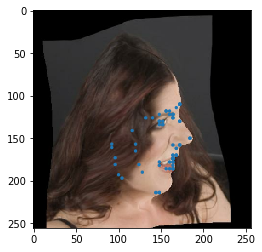

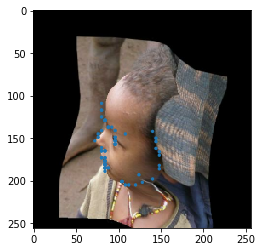

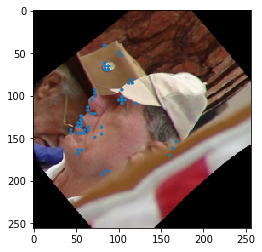

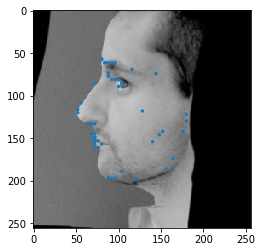

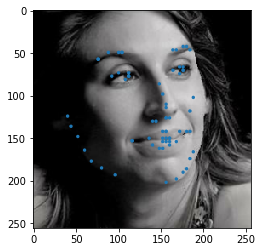

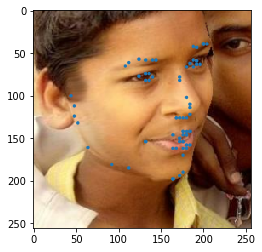

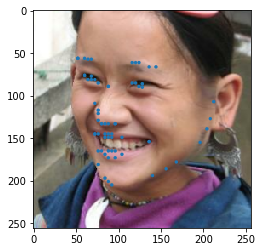

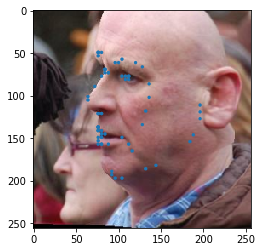

In [32]:
# eval
import tensorflow as tf
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os

from face_detection import face_detector
from face_landmark import model
from face_landmark import preprocess
from face_landmark import inputs
import scipy
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.patches import Circle
def draw(img, pts):    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    h, w, _ = img.shape
    xs = (pts[:,0]*w).astype(int)
    ys = (pts[:,1]*h).astype(int)
    for i in range(68):
        circ = Circle((xs[i], ys[i]),2)
        ax.add_patch(circ)
    ax.imshow(img)      
    return

with tf.Session(target='', graph=graph0, config=config) as sess:
    detector = face_detector.FaceDetector()
    dataset = inputs.get_tf_dataset('/barn2/yuan/datasets/300wlp_20181002.tfrecord', batch_size=1, detector=detector)
    #dataset = get_tf_dataset('/barn2/yuan/datasets/300W_LP/flat_dataset.record', batch_size=1, detector=detector)
    dataset = dataset.prefetch(buffer_size=200)
    iterator = dataset.make_initializable_iterator()
    next_example = iterator.get_next()
    image_tensor, heatmap_groundtruth_tensor = next_example

    print(image_tensor)
    print(heatmap_groundtruth_tensor)
    
    heatmap_inferred_tensors = model.fan(x=image_tensor, num_modules=4)
    print('inferred length: ', len(heatmap_inferred_tensors))


    saver = tf.train.Saver()
    saver.restore(sess, '../saved_model/face_landmark/80_8890_015')
     
    sess.run(iterator.initializer)
    cnt = 0
    while cnt < 10:
        try:
            img, heatmaps, real_heatmap = sess.run([image_tensor, heatmap_inferred_tensors, heatmap_groundtruth_tensor])
            heatmap = (heatmaps[0] + heatmaps[1] + heatmaps[2] + heatmaps[3]) / 4.0
            heatmap = heatmap[0]
            real_heatmap = real_heatmap[0]
            img = img[0]
            # img = scipy.misc.imresize(img, [512, 512])
            #print('img: ', img.min(), img.max(), img.shape)
            pts = preprocess.heatmap2pts(heatmap)
            #pts = preprocess.heatmap2pts(real_heatmap)
            #draw(img, pts)
            draw(((img + 1) / 2.0 *255).astype(np.uint8), pts)
            #draw(img, pts_real)
            cnt += 1
        
        except tf.errors.OutOfRangeError:
            print('!!')


Tensor("IteratorGetNext:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("IteratorGetNext:1", shape=(?, 64, 64, 68), dtype=float32)
in_channels: 64
out_channels: 128
in_channels: 128
out_channels: 256
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
previous shape: (?, 64, 64, 256)
low1 shape: (?, 32, 32, 256)
low1 shape: (?, 16, 16, 256)
low1 shape: (?, 8, 8, 256)
low1 shape: (?, 4, 4, 256)
inferred length:  4
INFO:tensorflow:Restoring parameters from ../saved_model/face_landmark/80_8890_015


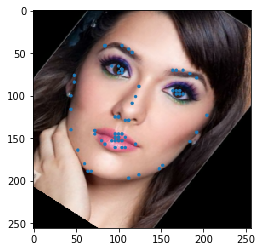

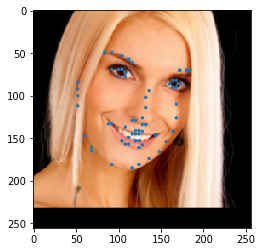

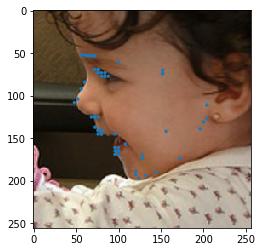

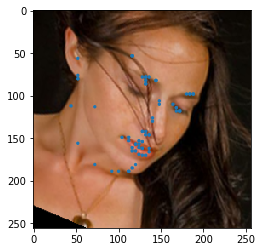

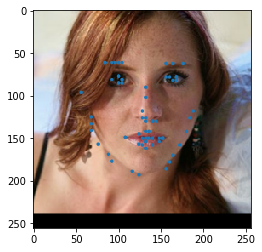

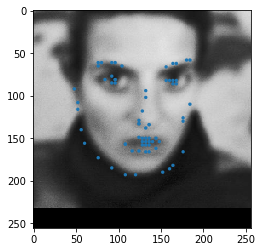

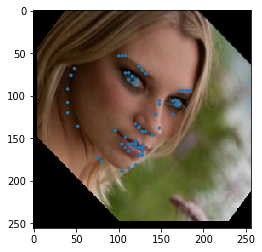

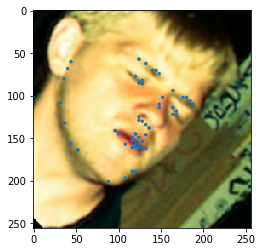

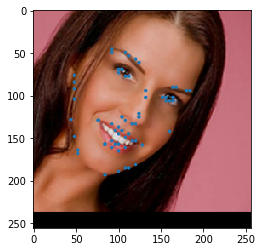

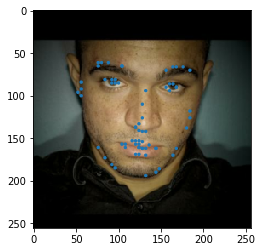

In [34]:
# eval on AFLW 2000

# eval
import tensorflow as tf
graph0 = tf.Graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
import os

from face_detection import face_detector
from face_landmark import model
from face_landmark import preprocess
from face_landmark import inputs
import scipy
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.patches import Circle
def draw(img, pts):    
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    h, w, _ = img.shape
    xs = (pts[:,0]*w).astype(int)
    ys = (pts[:,1]*h).astype(int)
    for i in range(68):
        circ = Circle((xs[i], ys[i]),2)
        ax.add_patch(circ)
    ax.imshow(img)      
    return

with tf.Session(target='', graph=graph0, config=config) as sess:
    detector = face_detector.FaceDetector()
    dataset = inputs.get_tf_dataset('/barn2/yuan/datasets/aflw2000_3d_20181002.tfrecord', batch_size=1, detector=detector)
    #dataset = get_tf_dataset('/barn2/yuan/datasets/300W_LP/flat_dataset.record', batch_size=1, detector=detector)
    dataset = dataset.prefetch(buffer_size=200)
    iterator = dataset.make_initializable_iterator()
    next_example = iterator.get_next()
    image_tensor, heatmap_groundtruth_tensor = next_example

    print(image_tensor)
    print(heatmap_groundtruth_tensor)
    
    heatmap_inferred_tensors = model.fan(x=image_tensor, num_modules=4)
    print('inferred length: ', len(heatmap_inferred_tensors))


    saver = tf.train.Saver()
    saver.restore(sess, '../saved_model/face_landmark/80_8890_015')
     
    sess.run(iterator.initializer)
    cnt = 0
    while cnt < 10:
        try:
            img, heatmaps, real_heatmap = sess.run([image_tensor, heatmap_inferred_tensors, heatmap_groundtruth_tensor])
            heatmap = (heatmaps[0] + heatmaps[1] + heatmaps[2] + heatmaps[3]) / 4.0
            heatmap = heatmap[0]
            real_heatmap = real_heatmap[0]
            img = img[0]
            # img = scipy.misc.imresize(img, [512, 512])
            #print('img: ', img.min(), img.max(), img.shape)
            pts = preprocess.heatmap2pts(heatmap)
            #pts = preprocess.heatmap2pts(real_heatmap)
            #draw(img, pts)
            draw(((img + 1) / 2.0 *255).astype(np.uint8), pts)
            #draw(img, pts_real)
            cnt += 1
        
        except tf.errors.OutOfRangeError:
            print('!!')


In [8]:
!pwd
!ls -al
!ls saved_model
!ls -al saved_model/face_landmark

/barn2/yuan/crafting/face_landmark/jupyter_notebooks
total 9796
drwxrwxrwx 4 yuanliu yuanliu    4096 Oct  3 11:15 .
drwxrwxrwx 9 bst     bst        4096 Oct  1 16:55 ..
-rw-rw-r-- 1 yuanliu yuanliu 4316656 Oct  2 16:36 benchmark.ipynb
-rw-rw-rw- 1 yuanliu yuanliu 4913790 Oct  2 18:39 create_heatmap.ipynb
drwxrwxrwx 2 yuanliu yuanliu    4096 Sep 17 14:57 .ipynb_checkpoints
drwxrwxr-x 3 yuanliu yuanliu    4096 Sep 21 15:39 saved_model
-rw-rw-r-- 1 yuanliu yuanliu  780921 Oct  3 11:15 train.ipynb
face_landmark
total 799288
drwxrwxr-x 3 yuanliu yuanliu      4096 Sep 24 08:54 .
drwxrwxr-x 3 yuanliu yuanliu      4096 Sep 21 15:39 ..
drwxrwxr-x 2 yuanliu yuanliu      4096 Sep 21 15:39 20180921_01
-rw-rw-r-- 1 yuanliu yuanliu 263356680 Sep 21 20:52 20180921_01.data-00000-of-00001
-rw-rw-r-- 1 yuanliu yuanliu     81993 Sep 21 20:52 20180921_01.index
-rw-rw-r-- 1 yuanliu yuanliu   9482562 Sep 21 20:52 20180921_01.meta
-rw-rw-r-- 1 yuanliu yuanliu 263356680 Sep 22 11:54 20180921_02.data-00000-of-

In [56]:
graph = tf.get_default_graph()
print(graph.as_graph_def())

versions {
  producer: 27
}



In [57]:
!pwd

/barn2/yuan/crafting/face_landmark/jupyter_notebooks


In [14]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.ones([7, 7])
d = np.array([a, b]).T
#print('d', d)
#print('a to list', a.tolist())
#print('b to list', b.tolist())
zi = zip(a.tolist(), b.tolist())
#print('zi', zi)
c[a, b] = 2
#ff = np.arange(20)
d1 = np.arange(20)
d1[[1, 2, 3]] = -1
print(d1)

[ 0 -1 -1 -1  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
